In [1]:
import numpy as np
import pandas as pd
import math
import random
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import gdown

In [2]:
"""Complete implementation of EpiInfer-CONTACT from the research paper:
UPDATED: Algorithm 2 now uses probabilistic sampling instead of deterministic top-N selection
"""

# ========== UTILITY FUNCTIONS ==========

def adjacency_from_pairs(contacts_per_day, population):
    """Convert contact pairs into adjacency dictionary for each day."""
    adj = {}
    for d, pairs in contacts_per_day.items():
        dayadj = {p: set() for p in population}
        for a, b in pairs:
            dayadj[a].add(b)
            dayadj[b].add(a)
        adj[d] = dayadj
    return adj

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return math.sqrt(mean_squared_error(y_true, y_pred))

# ========== ALGORITHM 3: FINDPROB ==========

def find_prob_exposure(adj_per_day, exposed_set, person, p1, day):
    """
    Algorithm 3 from paper: Calculate probability that susceptible person
    becomes exposed on given day based on contacts with exposed individuals.

    Returns: 1 - (1 - p1)^countEncounters
    """
    if day not in adj_per_day:
        return 0.0

    # Count encounters with exposed individuals
    encounters = len(adj_per_day[day].get(person, set()) & exposed_set)

    # Probability of NOT getting infected from all encounters
    return 1 - (1 - p1)**encounters if encounters > 0 else 0.0

# ========== ALGORITHM 2: PREDICT (UPDATED - PROBABILISTIC VERSION) ==========

def predict_exposures(adj_per_day, BelExp_d, BelSusc_d, p1, day):
    """
    Algorithm 2 from paper (UPDATED): Probabilistically predict who becomes newly exposed.

    CHANGE: Instead of selecting top N by probability, each susceptible person
    is independently exposed with their calculated probability p.

    CRITICAL: Uses EXPOSED population as infectious source (pre-symptomatic transmission)

    Strategy:
    1. Calculate exposure probability p for each susceptible
    2. For each susceptible, draw U ~ Uniform[0,1]
    3. If U < p, add person to newly exposed set

    Parameters:
    - adj_per_day: adjacency dictionary per day
    - BelExp_d: set of exposed/infectious people on day d
    - BelSusc_d: set of susceptible people on day d
    - p1: probability of exposure per contact
    - day: current day

    Returns: (set of newly exposed, dict of raw probabilities)
    """
    # Calculate exposure probability for each susceptible
    raw_probs = {s: find_prob_exposure(adj_per_day, BelExp_d, s, p1, day)
                 for s in BelSusc_d}

    # Probabilistic sampling: each person independently exposed with probability p
    newly_exposed = set()
    for person, prob in raw_probs.items():
        if prob > 0:
            # Draw uniform random number
            U = random.random()
            if U < prob:
                newly_exposed.add(person)

    return newly_exposed, raw_probs

In [3]:
class EpiInferContact:
    """
    Main class implementing all EpiInfer-CONTACT algorithms.
    UPDATED: Uses probabilistic predict_exposures function.
    """

    def __init__(self, population, contacts_per_day=None):
        """
        Initialize with population and optional contact tracing data.

        Parameters:
        - population: list of individual IDs
        - contacts_per_day: dict {day: [(person_a, person_b), ...]}
        """
        self.population = list(population)
        self.pop_set = set(population)
        self.contacts_adj = adjacency_from_pairs(contacts_per_day, population) if contacts_per_day else {}

    def _count_total_contacts(self, person):
        """Helper: Count total contacts for a person across all available days."""
        total = 0
        for day_adj in self.contacts_adj.values():
            total += len(day_adj.get(person, set()))
        return total

    def _initialize_exposed_from_infected(self, initial_infected, p2):
        """
        Smart initialization of exposed population.

        Strategy:
        - Estimate exposed count = len(initial_infected) / p2
        - Assign exposure to individuals with most contacts (highest risk)

        Returns: set of initially exposed individuals
        """
        # Estimate number of exposed based on infected count
        estimated_exposed_count = int(round(len(initial_infected) / p2)) if p2 > 0 else 0

        if estimated_exposed_count == 0:
            return set()

        # Exclude already infected from consideration
        candidates = self.pop_set - initial_infected

        if not candidates:
            return set()

        # Count total contacts for each candidate
        contact_counts = {person: self._count_total_contacts(person) for person in candidates}

        # Sort by contact count (descending) and select top N
        sorted_candidates = sorted(contact_counts.items(), key=lambda x: -x[1])
        exposed_count = min(estimated_exposed_count, len(sorted_candidates))
        initial_exposed = {person for person, _ in sorted_candidates[:exposed_count]}

        return initial_exposed

    # ========== ALGORITHM 1: CONTACTINFER-CORE (USES UPDATED PREDICT) ==========

    def contactinfer_run(self, p1, p2, inc, initial_infected,
                         initial_exposed=None,
                         max_day=20,
                         duration_infected=7,
                         duration_recovered=14,
                         stochastic=True):
        """
        Algorithm 1 from paper: Main contact-tracing inference loop.
        UPDATED: Now uses probabilistic predict_exposures function.

        Parameters:
        - p1: probability of exposure per contact with exposed person
        - p2: probability exposed person becomes infected
        - inc: incubation period (days)
        - initial_infected: set of initially infected individuals
        - initial_exposed: set of initially exposed (if None, computed from infected/p2)
        - max_day: number of days to simulate
        - duration_infected: how long someone stays infected
        - duration_recovered: how long someone stays recovered (immune)
        - stochastic: if True, use probabilistic sampling; if False, use expected values

        Returns: DataFrame with daily statistics
        """
        # Initialize exposed from infected if not provided
        if initial_exposed is None:
            initial_exposed = self._initialize_exposed_from_infected(initial_infected, p2)
            print(f"Initialized {len(initial_exposed)} exposed individuals based on {len(initial_infected)} infected (ratio: 1/{p2:.2f})")

        # Initialize tracking dictionaries
        self.BelNewExp = defaultdict(set)
        self.BelNewInf = defaultdict(set)
        self.BelNewRec = defaultdict(set)
        self.BelExp = defaultdict(set)
        self.BelInf = defaultdict(set)
        self.BelRec = defaultdict(set)

        # Day 1 initialization
        self.BelNewExp[1] = set(initial_exposed)
        self.BelNewInf[1] = set(initial_infected)
        self.BelExp[1] = set(initial_exposed)
        self.BelInf[1] = set(initial_infected)
        self.BelRec[1] = set()

        records = []

        for d in range(1, max_day + 1):
            # Current state
            exp_d = self.BelExp[d]
            inf_d = self.BelInf[d]
            rec_d = self.BelRec[d]

            # Susceptible = Everyone - (Exposed ∪ Infected ∪ Recovered)
            susc_d = self.pop_set - (exp_d | inf_d | rec_d)

            # UPDATED: Algorithm 2 now uses probabilistic sampling
            # CRITICAL FIX: Use EXPOSED people as infectious source (they're pre-symptomatic but contagious)
            # This matches the biological reality that exposed individuals can transmit before showing symptoms
            new_exp, raw_probs = predict_exposures(self.contacts_adj, exp_d, susc_d, p1, d)
            self.BelNewExp[d + 1] = new_exp

            # CRITICAL FIX: Active exposed = exposures within incubation window (not yet infected)
            # People leave E compartment when they become infected (after inc days)
            window_exp = range(max(1, d + 1 - inc + 1), d + 2)
            active_exp = set().union(*[self.BelNewExp[t] for t in window_exp])
            self.BelExp[d + 1] = active_exp

            # Algorithm 1 Line 8: Infections from exposures inc days ago
            src_day = d + 1 - inc
            new_inf = set()

            if src_day >= 1:
                old_exp = self.BelNewExp[src_day]

                if stochastic:
                    # Each individual becomes infected with probability p2
                    new_inf = {e for e in old_exp if random.random() < p2}
                else:
                    # Deterministic approximation using expected value
                    k = int(round(p2 * len(old_exp)))
                    if k > 0 and len(old_exp) > 0:
                        new_inf = set(random.sample(list(old_exp), min(k, len(old_exp))))

            self.BelNewInf[d + 1] = new_inf

            # Active infections = all infections within duration window
            window_inf = range(max(1, d + 1 - duration_infected + 1), d + 2)
            active_inf = set().union(*[self.BelNewInf[t] for t in window_inf])
            self.BelInf[d + 1] = active_inf

            # Track recoveries
            recovery_day = d + 1 - duration_infected
            if recovery_day >= 1:
                new_rec = self.BelNewInf[recovery_day]
                self.BelNewRec[d + 1] = new_rec
            else:
                self.BelNewRec[d + 1] = set()

            # Active recovered = all recoveries within duration_recovered window
            window_rec = range(max(1, d + 1 - duration_recovered + 1), d + 2)
            active_rec = set().union(*[self.BelNewRec[t] for t in window_rec])
            self.BelRec[d + 1] = active_rec

            records.append({
                "day": d,
                "new_exposed": len(new_exp),
                "new_infected": len(new_inf),
                "new_recovered": len(self.BelNewRec[d + 1]),
                "total_exposed": len(self.BelExp[d + 1]),
                "total_infected": len(self.BelInf[d + 1]),
                "total_recovered": len(self.BelRec[d + 1]),
                "total_susceptible": len(susc_d),
                "expected_new_exposed": sum(raw_probs.values())
            })

        return pd.DataFrame(records)

    # ========== ALGORITHM 4: EPIINFER-CORE ==========

    def simulate_epiinfer_core(self, p1, p2, inc, NewInf_hist, asymp_hist,
                              recovered_hist, mean_meetings, max_day):
        """
        Algorithm 4 from paper: Meeting-distribution based inference.
        """
        NewInf = defaultdict(int, NewInf_hist)
        asymp = defaultdict(int, asymp_hist)
        recovered = defaultdict(int, recovered_hist)
        preds = {}

        for d in range(1, max_day + 1):
            t = d - inc

            if t < 1:
                preds[d] = NewInf.get(d, 0)
                continue

            numerator = sum([NewInf.get(d - i, 0) for i in range(1, inc + 1)])
            denominator = p2 * max(1, asymp[t])
            palreadyexp = min(numerator / denominator, 1.0) if denominator > 0 else 0

            mean_contacts = mean_meetings.get(t, 0)
            p_newexposed = 1 - (1 - p1) ** (mean_contacts * palreadyexp)

            already_exposed_count = numerator / p2 if p2 > 0 else 0
            asymptomaticNotEx = (asymp[t]
                                - already_exposed_count
                                - recovered.get(t, 0))
            asymptomaticNotEx = max(0, asymptomaticNotEx)

            NewExposed = asymptomaticNotEx * p_newexposed
            preds[d] = int(round(p2 * NewExposed))
            NewInf[d] = preds[d]

        return preds

    # ========== ALGORITHM 5: CONTINUOUSCALIBRATE ==========

    def continuous_calibrate(self, observed_newinf, inc, mean_meetings,
                           asymp_hist=None, recovered_hist=None,
                           p2_values=None, training_window=5, verbose=False):
        """
        Algorithm 5 from paper: Find optimal p1 and p2 parameters.
        """
        if p2_values is None:
            p2_values = [round(x, 2) for x in np.arange(0.1, 1.01, 0.1)]

        days = sorted(observed_newinf.keys())
        if asymp_hist is None:
            asymp_hist = {d: len(self.population) for d in days}
        if recovered_hist is None:
            recovered_hist = {d: 0 for d in days}

        end_day = max(days)
        start_day = max(1, end_day - training_window + 1)
        obs = [observed_newinf.get(d, 0) for d in range(start_day, end_day + 1)]

        best = {"p1": None, "p2": None, "rmse": float("inf")}

        for p2 in p2_values:
            lo, hi = 0.0, 1.0

            for iteration in range(15):
                mid = (lo + hi) / 2.0

                preds = self.simulate_epiinfer_core(
                    mid, p2, inc,
                    {1: observed_newinf.get(1, 0)},
                    asymp_hist,
                    recovered_hist,
                    mean_meetings,
                    end_day
                )

                pred = [preds.get(d, 0) for d in range(start_day, end_day + 1)]
                error = rmse(obs, pred)

                if error < best["rmse"]:
                    best.update({"p1": mid, "p2": p2, "rmse": error})

                if np.mean(pred) > np.mean(obs):
                    hi = mid
                else:
                    lo = mid

            if verbose:
                print(f"p2={p2:.1f} → best_p1≈{best['p1']:.3f}, RMSE={best['rmse']:.3f}")

        return best


In [4]:
gdown.download('https://drive.google.com/file/d/1rV60qkWgC3hS1F7061mAEyUz8xEQyI4d/view?usp=sharing', fuzzy=True)
gdown.download('https://docs.google.com/spreadsheets/d/12SxTHwdj1w7PaphOweNh58cSewkp8T9l/edit?usp=sharing&ouid=107283854447072019551&rtpof=true&sd=true', fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1rV60qkWgC3hS1F7061mAEyUz8xEQyI4d
To: /content/states_total.csv
100%|██████████| 914/914 [00:00<00:00, 2.45MB/s]
Downloading...
From: https://drive.google.com/uc?id=12SxTHwdj1w7PaphOweNh58cSewkp8T9l
To: /content/daily_contacts_multisheet.xlsx
100%|██████████| 27.8M/27.8M [00:00<00:00, 52.6MB/s]


'daily_contacts_multisheet.xlsx'

In [5]:
# ========== DATA LOADING FUNCTIONS ==========

def load_states_data(filepath='states_total.csv'):
    """Load the SEIR states data."""
    df = pd.read_csv(filepath)
    return df

def load_contact_data(filepath='daily_contacts_multisheet.xlsx', max_days=50):
    """
    Load contact data from Excel file with multiple sheets.
    Returns: dict {day: [(person_a, person_b), ...]}
    """
    contacts_per_day = {}

    for day in range(1, max_days + 1):
        sheet_name = f'Day_{day}'
        try:
            df = pd.read_excel(filepath, sheet_name=sheet_name)

            if 'Person_A_ID' in df.columns and 'Person_B_ID' in df.columns:
                person_a = df['Person_A_ID'].dropna()
                person_b = df['Person_B_ID'].dropna()
            else:
                person_a = df.iloc[:, 1].dropna()
                person_b = df.iloc[:, 3].dropna()

            pairs = list(zip(person_a, person_b))
            contacts_per_day[day] = pairs

            print(f"Loaded {len(pairs)} contacts for Day {day}")

        except Exception as e:
            print(f"Warning: Could not load Day_{day}: {e}")
            contacts_per_day[day] = []

    return contacts_per_day

def extract_population(contacts_per_day):
    """Extract unique population IDs from contact data."""
    population = set()
    for day, pairs in contacts_per_day.items():
        for a, b in pairs:
            population.add(a)
            population.add(b)
    return list(population)

def calculate_mean_meetings(contacts_per_day, population):
    """Calculate mean number of meetings per person per day."""
    mean_meetings = {}

    for day, pairs in contacts_per_day.items():
        contact_count = defaultdict(int)
        for a, b in pairs:
            contact_count[a] += 1
            contact_count[b] += 1

        if len(population) > 0:
            total_contacts = sum(contact_count.values())
            mean_meetings[day] = total_contacts / len(population)
        else:
            mean_meetings[day] = 0

    return mean_meetings

def grid_search_parameters(model, states_df, population, contacts_per_day,
                          initial_infected, initial_exposed, max_day=50):
    """
    Perform grid search to find optimal parameters.
    Tests multiple combinations of p1, p2, inc, and durations.
    """
    print("\n" + "="*60)
    print("GRID SEARCH FOR OPTIMAL PARAMETERS (PROBABILISTIC VERSION)")
    print("="*60)

    # Wider parameter ranges to capture explosive growth pattern
    p1_values = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]  # Higher transmission per contact
    p2_values = [0.5, 0.6, 0.7, 0.8, 0.9]  # Higher progression to infected
    inc_values = [2, 3, 4, 5]  # Shorter incubation periods
    duration_infected_values = [5, 7, 10]  # Various infection durations

    best_rmse = float('inf')
    best_config = None
    results_list = []

    total_tests = len(p1_values) * len(p2_values) * len(inc_values) * len(duration_infected_values)
    test_num = 0

    for p1 in p1_values:
        for p2 in p2_values:
            for inc in inc_values:
                for dur_inf in duration_infected_values:
                    test_num += 1

                    try:
                        # Run multiple simulations and average (due to stochasticity)
                        num_runs = 5
                        all_infected = []

                        for run in range(num_runs):
                            results_df = model.contactinfer_run(
                                p1=p1,
                                p2=p2,
                                inc=inc,
                                initial_infected=initial_infected,
                                initial_exposed=initial_exposed,
                                max_day=max_day,
                                duration_infected=dur_inf,
                                duration_recovered=100,
                                stochastic=True
                            )
                            all_infected.append(results_df['total_infected'].values)

                        # Average across runs
                        predicted_infected = np.mean(all_infected, axis=0)

                        # Calculate RMSE
                        actual_infected = states_df['I'].values[:len(predicted_infected)]
                        rmse_infected = math.sqrt(np.mean((actual_infected - predicted_infected) ** 2))

                        # Peak metrics
                        actual_peak_day = states_df['I'].idxmax()
                        pred_peak_day = int(np.argmax(predicted_infected))
                        peak_diff = abs(actual_peak_day - pred_peak_day)

                        actual_peak_val = states_df['I'].max()
                        pred_peak_val = predicted_infected.max()
                        peak_ratio = pred_peak_val / actual_peak_val if actual_peak_val > 0 else 1.0

                        peak_penalty = 100 * max(0, peak_diff - 3)
                        rmse_val = rmse_infected + peak_penalty

                        results_list.append({
                            'p1': p1,
                            'p2': p2,
                            'inc': inc,
                            'dur_inf': dur_inf,
                            'rmse': rmse_val,
                            'rmse_infected': rmse_infected,
                            'peak_diff': peak_diff,
                            'peak_ratio': peak_ratio
                        })

                        if rmse_val < best_rmse:
                            best_rmse = rmse_val
                            best_config = {
                                'p1': p1,
                                'p2': p2,
                                'inc': inc,
                                'duration_infected': dur_inf,
                                'rmse': rmse_val,
                                'rmse_infected': rmse_infected,
                                'peak_diff': peak_diff,
                                'peak_ratio': peak_ratio
                            }
                            print(f"[{test_num}/{total_tests}] ⭐ New best! p1={p1:.3f}, p2={p2:.1f}, inc={inc}, dur={dur_inf}")
                            print(f"    → RMSE(I)={rmse_infected:.1f}, peak_day_diff={peak_diff}, peak_ratio={peak_ratio:.2f}")

                    except Exception as e:
                        print(f"[{test_num}/{total_tests}] Failed: {e}")
                        continue

    print("\n" + "="*60)
    print("GRID SEARCH COMPLETE")
    print("="*60)
    print(f"\n🏆 Best Configuration:")
    print(f"  p1 (exposure prob per contact): {best_config['p1']:.4f}")
    print(f"  p2 (exposed → infected prob): {best_config['p2']:.2f}")
    print(f"  inc (incubation period): {best_config['inc']} days")
    print(f"  duration_infected: {best_config['duration_infected']} days")
    print(f"\n📊 Performance Metrics:")
    print(f"  RMSE (Infected): {best_config['rmse_infected']:.2f}")
    print(f"  Peak day difference: {best_config['peak_diff']} days")
    print(f"  Peak magnitude ratio: {best_config['peak_ratio']:.2f}")

    results_grid_df = pd.DataFrame(results_list)
    results_grid_df = results_grid_df.sort_values('rmse')
    results_grid_df.to_csv('grid_search_results_probabilistic.csv', index=False)
    print(f"\n💾 Saved results to 'grid_search_results_probabilistic.csv'")
    print(f"\n📋 Top 10 configurations:")
    print(results_grid_df[['p1', 'p2', 'inc', 'dur_inf', 'rmse_infected', 'peak_diff']].head(10).to_string(index=False))

    return best_config


In [6]:
# ========== MAIN ANALYSIS ==========

def main():
    """Main analysis pipeline with probabilistic predict."""

    print("=" * 60)
    print("EpiInfer-CONTACT - PROBABILISTIC PREDICT VERSION")
    print("="  * 60)

    # Load data
    print("\n1. Loading SEIR states data...")
    states_df = load_states_data('states_total.csv')
    print(f"Loaded {len(states_df)} days of data")

    print("\n2. Loading contact tracing data...")
    contacts_per_day = load_contact_data('daily_contacts_multisheet.xlsx', max_days=50)

    print("\n3. Extracting population...")
    population = extract_population(contacts_per_day)
    print(f"Unique individuals: {len(population)}")

    print("\n4. Initializing model...")
    model = EpiInferContact(population, contacts_per_day)

    # Set up initial conditions
    print("\n5. Setting up initial conditions...")
    day0 = states_df[states_df['day'] == 0].iloc[0]
    initial_exposed_count = int(day0['E'])
    initial_infected_count = int(day0['I']) if day0['I'] > 0 else 1

    initial_infected = set(random.sample(population, min(initial_infected_count, len(population))))
    remaining_pop = list(set(population) - initial_infected)
    initial_exposed = set(random.sample(remaining_pop, min(initial_exposed_count, len(remaining_pop))))

    print(f"Initial exposed: {len(initial_exposed)}")
    print(f"Initial infected: {len(initial_infected)}")

    # Grid search
    print("\n6. Performing grid search...")
    best_config = grid_search_parameters(
        model, states_df, population, contacts_per_day,
        initial_infected, initial_exposed, max_day=50
    )

    # Run with best parameters
    print(f"\n7. Running final simulation with best parameters...")
    print(f"Parameters: p1={best_config['p1']:.4f}, p2={best_config['p2']:.2f}, inc={best_config['inc']}")

    results_df = model.contactinfer_run(
        p1=best_config['p1'],
        p2=best_config['p2'],
        inc=best_config['inc'],
        initial_infected=initial_infected,
        initial_exposed=initial_exposed,
        max_day=50,
        duration_infected=best_config['duration_infected'],
        duration_recovered=100,
        stochastic=True
    )

    print("\nResults (first 10 days):")
    print(results_df.head(10))

    # Visualize
    print("\n8. Generating visualizations...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    ax1 = axes[0, 0]
    ax1.plot(states_df['day'], states_df['I'], 'o-', label='Actual Infected', linewidth=2)
    ax1.plot(results_df['day'], results_df['total_infected'], 's-', label='Predicted Infected', linewidth=2)
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Count')
    ax1.set_title('Infected: Actual vs Predicted (Probabilistic)')
    ax1.legend()
    ax1.grid(True)

    ax2 = axes[0, 1]
    ax2.plot(states_df['day'], states_df['S'], label='Susceptible')
    ax2.plot(states_df['day'], states_df['E'], label='Exposed')
    ax2.plot(states_df['day'], states_df['I'], label='Infected')
    ax2.plot(states_df['day'], states_df['R'], label='Recovered')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Count')
    ax2.set_title('Actual SEIR Compartments')
    ax2.legend()
    ax2.grid(True)

    ax3 = axes[1, 0]
    ax3.plot(results_df['day'], results_df['total_susceptible'], label='Susceptible')
    ax3.plot(results_df['day'], results_df['total_exposed'], label='Exposed')
    ax3.plot(results_df['day'], results_df['total_infected'], label='Infected')
    ax3.plot(results_df['day'], results_df['total_recovered'], label='Recovered')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Count')
    ax3.set_title('Predicted SEIR Compartments (Probabilistic)')
    ax3.legend()
    ax3.grid(True)

    ax4 = axes[1, 1]
    ax4.bar(results_df['day'], results_df['new_infected'], alpha=0.7, label='New Infected')
    ax4.bar(results_df['day'], results_df['new_exposed'], alpha=0.7, label='New Exposed')
    ax4.set_xlabel('Day')
    ax4.set_ylabel('Count')
    ax4.set_title('Daily New Cases (Probabilistic)')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig('epiinfer_results_probabilistic.png', dpi=300, bbox_inches='tight')
    print("Saved visualization to 'epiinfer_results_probabilistic.png'")
    plt.show()

    # Metrics
    print("\n9. Performance Metrics:")
    actual_infected = states_df['I'].values[:len(results_df)]
    predicted_infected = results_df['total_infected'].values
    rmse_infected = math.sqrt(np.mean((actual_infected - predicted_infected) ** 2))
    mae_infected = np.mean(np.abs(actual_infected - predicted_infected))
    print(f"RMSE (Infected): {rmse_infected:.2f}")
    print(f"MAE (Infected): {mae_infected:.2f}")

    # Save results
    print("\n10. Saving results...")
    results_df.to_csv('contactinfer_results_probabilistic.csv', index=False)
    print("Saved to 'contactinfer_results_probabilistic.csv'")

    print("\n" + "=" * 60)
    print("Analysis Complete!")
    print("=" * 60)

EpiInfer-CONTACT - PROBABILISTIC PREDICT VERSION

1. Loading SEIR states data...
Loaded 51 days of data

2. Loading contact tracing data...
Loaded 23403 contacts for Day 1
Loaded 23559 contacts for Day 2
Loaded 23459 contacts for Day 3
Loaded 23224 contacts for Day 4
Loaded 23064 contacts for Day 5
Loaded 22553 contacts for Day 6
Loaded 21988 contacts for Day 7
Loaded 19935 contacts for Day 8
Loaded 15889 contacts for Day 9
Loaded 10809 contacts for Day 10
Loaded 7936 contacts for Day 11
Loaded 7293 contacts for Day 12
Loaded 8288 contacts for Day 13
Loaded 11419 contacts for Day 14
Loaded 15383 contacts for Day 15
Loaded 17750 contacts for Day 16
Loaded 18629 contacts for Day 17
Loaded 19738 contacts for Day 18
Loaded 21123 contacts for Day 19
Loaded 21792 contacts for Day 20
Loaded 22651 contacts for Day 21
Loaded 23134 contacts for Day 22
Loaded 23163 contacts for Day 23
Loaded 23242 contacts for Day 24
Loaded 23121 contacts for Day 25
Loaded 23597 contacts for Day 26
Loaded 23164 c

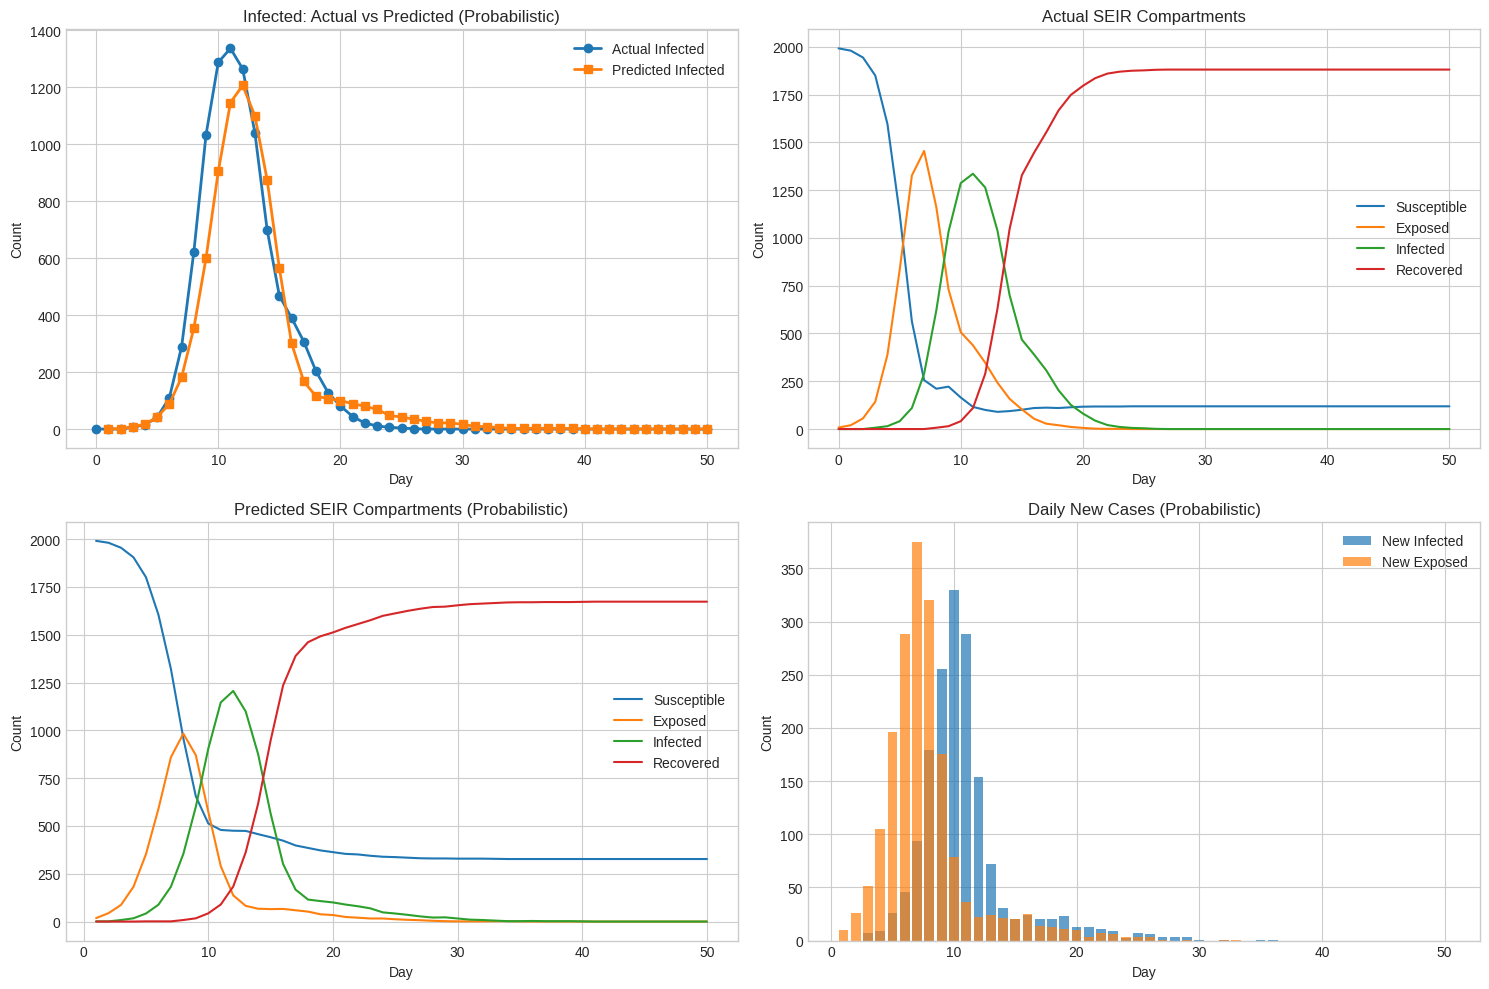


9. Performance Metrics:
RMSE (Infected): 73.83
MAE (Infected): 42.78

10. Saving results...
Saved to 'contactinfer_results_probabilistic.csv'

Analysis Complete!


In [7]:
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    main()